# Notebook Setup

In [35]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## Generating Pseudo Dataset

To keep this simple, we will create an artificial dataset with added noise. We will try to train a model to learn the parameters of the model which we know from the beginning. We will generate a dataset of 1000 samples where each sample has 2 features.

True parameters used in our dataset will be __w__ = $[2, -3.4]^{T}$ and _b_ = 4.2. 

Then, the examples in our dataset will be drawn according to the following equation:

$$
\textbf{y} = \textbf{X}\textbf{w} + b + \epsilon
$$

We will assume that the $\epsilon$ obeys a normal distribution with mean 0 and standard deviation of 0.01

In [36]:
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [37]:
print("features:", features[0], '\nlabels:', labels[0])

features: tensor([ 1.9724, -0.2796]) 
labels: tensor([9.1080])


We can visualize our synthetic data with a scatter plot

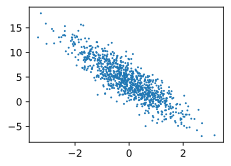

In [38]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

## Dataset Shuffle

Because we will need a randomly selected mini-batch size of examples each time we want to pass through our model, we can define a custom function for this purpose. 

In [50]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(num_examples,i+batch_size)])
        yield features[batch_indices], labels[batch_indices]

In [51]:
batch_size = 10

for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.4390, -2.8529],
        [ 0.1362, -0.3652],
        [ 1.8379, -0.4287],
        [ 0.8617, -0.3304],
        [-0.6942,  1.6339],
        [-1.5254, -0.1371],
        [-0.0340, -0.8699],
        [-0.1964,  0.3531],
        [-1.2498, -0.0527],
        [ 0.9346,  0.6377]]) 
 tensor([[14.7735],
        [ 5.7062],
        [ 9.3329],
        [ 7.0533],
        [-2.7531],
        [ 1.6286],
        [ 7.0914],
        [ 2.6146],
        [ 1.8846],
        [ 3.9207]])


## Initializing Model Parameters

In [58]:
w = torch.normal(0, 1, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

## Defining Our Model

In [59]:
def linreg(X, w, b):
    return torch.matmul(X,w) + b

## Defining The Loss Function

In [60]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

## Defining The Optimization Algorithm

At each step, using one minibatch randomly drawn from our dataset, we will estimate hte gradient of the loss with respect to w and b; then we will update them according to the gradient descent.

Because our copst is calculated as a sum over the minibatch of examples, we normalize our step size by the batch size. We do this so that the magnitude of a typical step size does not depend heavily on the choice of batch size

In [61]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## Training

In each iteration, we will grab a minibatch of examples and feed them to our network to return predictions for each example. We will use these predictions to calculate our loss function. Then, we will initiate the backward pass through the network while storing the gradients with respect to each parameter. Finally, we will call the optimization algorithm to update the model parameters.

In [62]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X,y in data_iter(batch_size, features, labels):
        l = loss(net(X,w,b),y)
        l.sum().backward()
        sgd([w,b], lr, batch_size)
        
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.030500
epoch 2, loss 0.000109
epoch 3, loss 0.000051


In [63]:
print(f'error in estimating w: {true_w - w.reshape(true_w.shape)}')
print(f'error in estimating b: {true_b - b}')

error in estimating w: tensor([1.4174e-04, 3.7670e-05], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.0007], grad_fn=<RsubBackward1>)
